# Project Outline: Minimizing SUMMA Model Misfits at the Cues Site
CVU - Intro to Snow Hydrology: Focus on Modeling

Bareera Mirza & Rainey Aberle

29 October 2021

__Notes:__ 
- This notebook requires the 'cues' folder
- CUES (CRREL/UCSB Energy Site) energy balance site, Mammoth Mountain, California [elev. 2940 m]

#### SUMMA parameters / decisions tested to minimize misfits with site observations:
1. Layering scheme: CLM, JRDN, thin 2-layer, thick 2-layer
2. `snowIncept`: `stickySnow` vs. `lightSnow`
3. 
4. 
5. 

#### Set path to the cues folder

In [ ]:
homepath = '/home/jovyan/data/cues/'

#### Import Packages

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt # if you want to do some plotting using matplotlib (optional)
import numpy as np # provide some mathematical functions
import xarray as xr # read, write, manipulate and analyze NetCDF files
from pathlib import Path
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
import warnings
warnings.filterwarnings('ignore')
import pysumma as ps
import csv
import pandas as pd
from datetime import date
from sklearn.metrics import mean_squared_error

#### Load observed daily snow depth at the site

In [3]:
obs_file = str(homepath+'data/CUESDailySnowDepth20010320to20150428.csv')
obs = pd.read_csv(obs_file, sep=',')
obs

,date,snowdepth_cm
0,2001-03-20,367.70
1,2001-03-21,284.45
2,2001-03-22,278.20
3,2001-03-23,277.55
4,2001-03-24,275.10
...,...,...
5148,2015-04-24,44.25
5149,2015-04-25,56.65
5150,2015-04-26,52.40
5151,2015-04-27,45.40


#### Setup the SUMMA executable and file manager

In [4]:
executable = 'summa.exe'
filemanager = str(homepath+'summa_setup/settings/file_manager_cues.txt')
filemanager

'/home/jovyan/data/cues/summa_setup/settings/file_manager_cues.txt'

### 1. Layering scheme

In [5]:
# ----------CLM----------

# Initialize simulation
s_clm = ps.Simulation(executable, filemanager)

# Set the simulation start and end times
#    - snow depth observations available: 2001-03-20 to 2015-04-28
#    - forcing files available: 2011 - 2017
s_clm.manager['simStartTime'] = '2011-10-01 00:00'
s_clm.manager['simEndTime'] = '2015-04-28 00:00'
    
# Add some additional variables to the outputs
output_settings = {'period': 1, 'instant': 1, 'sum': 0, 
              'mean': 0, 'variance': 0, 'min': 0, 'max': 0}
layer_vars = ['mLayerTemp', 'mLayerDepth', 'mLayerHeight',
              'mLayerLiqFluxSoil', 'mLayerVolFracIce', 'mLayerVolFracLiq', 
              'mLayerVolFracWat','mLayerMatricHead', 'iLayerHeight', 'scalarSnowDepth', 'nSnow']

# Create the new output variables
for var in layer_vars:
    s_clm.output_control[var] = output_settings

# Ensure all variables have the same statistics
all_vars = set(layer_vars + [o.name for o in s_clm.output_control.options])
for var in all_vars:
    s_clm.output_control[var] = output_settings

# Run simulation
s_clm.run('local', run_suffix='CLM_2010')
s_clm.status

'Success'

In [6]:
# ----------JRDN----------

# Initialize simulation
s_jrdn = ps.Simulation(executable, filemanager)

# Set the simulation start and end times
s_jrdn.manager['simStartTime'] = '2011-10-01 00:00'
s_jrdn.manager['simEndTime'] = '2015-04-28 00:00'

# Change layers deicision
s_jrdn.decisions['snowLayers'] = 'jrdn1991'
    
# Create the new output variables
for var in layer_vars:
    s_jrdn.output_control[var] = output_settings

# Ensure all variables have the same statistics
all_vars = set(layer_vars + [o.name for o in s_jrdn.output_control.options])
for var in all_vars:
    s_jrdn.output_control[var] = output_settings
    
# Run simulation
s_jrdn.run('local', run_suffix='_jrdn')
s_jrdn.status

'Success'

In [7]:
# ----------Thin 2-layer----------
# Initialize simulation
s_thin = ps.Simulation(executable, filemanager)

# Set the simulation start and end times
s_thin.manager['simStartTime'] = '2011-10-01 00:00'
s_thin.manager['simEndTime'] = '2015-04-28 00:00'

# Change layers decision
s_thin.decisions['snowLayers'] = 'CLM_2010'

# Modify layers
s_thin.global_hru_params['zminLayer3'] = 100.0000
s_thin.global_hru_params['zminLayer4'] = 100.0000
s_thin.global_hru_params['zminLayer5'] = 100.0000
s_thin.global_hru_params['zmaxLayer2_lower'] = 1000.0000
s_thin.global_hru_params['zmaxLayer3_lower'] = 1000.0000
s_thin.global_hru_params['zmaxLayer4_lower'] = 1000.0000
s_thin.global_hru_params['zmaxLayer2_upper'] = 1000.0000
s_thin.global_hru_params['zmaxLayer3_upper'] = 1000.0000
s_thin.global_hru_params['zmaxLayer4_upper'] = 1000.0000

# Create the new output variables
for var in layer_vars:
    s_thin.output_control[var] = output_settings

# Ensure all variables have the same statistics
all_vars = set(layer_vars + [o.name for o in s_thin.output_control.options])
for var in all_vars:
    s_thin.output_control[var] = output_settings
    
# Run simulation
s_thin.run('local', run_suffix='_thin2layer')
s_thin.status

'Success'

In [8]:
# ----------Thick 2-layer----------
# Initialize simulation
s_thick = ps.Simulation(executable, filemanager)

# Set the simulation start and end times
s_thick.manager['simStartTime'] = '2011-10-01 00:00'
s_thick.manager['simEndTime'] = '2015-04-28 00:00'

# Change the layering decision
s_thick.decisions['snowLayers'] = 'CLM_2010'

# Modify layers
s_thick.global_hru_params['zminLayer1'] = 0.050
s_thick.global_hru_params['zminLayer2'] = 0.020
s_thick.global_hru_params['zminLayer3'] = 100.0
s_thick.global_hru_params['zminLayer4'] = 100.0
s_thick.global_hru_params['zminLayer5'] = 100.0
s_thick.global_hru_params['zmaxLayer1_lower'] = 0.2000
s_thick.global_hru_params['zmaxLayer2_lower'] = 1000.0
s_thick.global_hru_params['zmaxLayer3_lower'] = 1000.0
s_thick.global_hru_params['zmaxLayer4_lower'] = 1000.0
s_thick.global_hru_params['zmaxLayer1_upper'] = 0.1500
s_thick.global_hru_params['zmaxLayer2_upper'] = 1000.0
s_thick.global_hru_params['zmaxLayer3_upper'] = 1000.0
s_thick.global_hru_params['zmaxLayer4_upper'] = 1000.0

# Create the new output variables
for var in layer_vars:
    s_thick.output_control[var] = output_settings

# Ensure all variables have the same statistics
all_vars = set(layer_vars + [o.name for o in s_thick.output_control.options])
for var in all_vars:
    s_thick.output_control[var] = output_settings
    
# Run simulation
s_thick.run('local', run_suffix='_thick2layer')
s_thick.status

'Success'

In [9]:
# Convert observed dates to datetime format
obs['date'] = pd.to_datetime(obs['date'])

# Interpolate the snow depth observations onto the simulation time period
obs_interp = np.interp(s_clm.output['time'],obs['date'],obs['snowdepth_cm'])

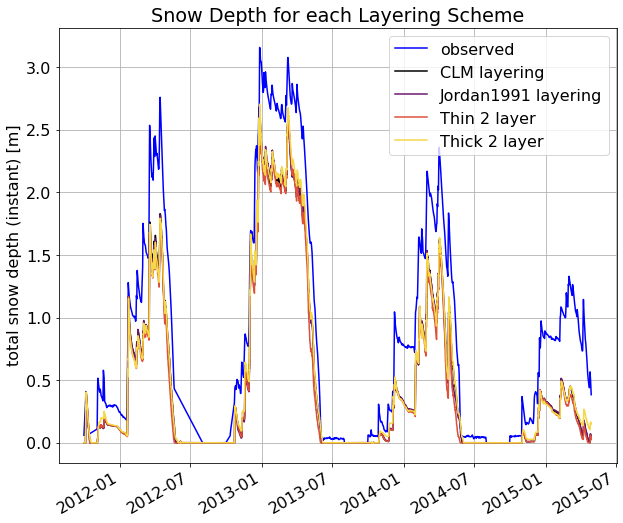

In [10]:
# Plot results
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 16})
plt.plot(s_clm.output['time'],obs_interp/100, label='observed', color='blue')
s_clm.output['scalarSnowDepth'].plot(label='CLM layering', color=plt.cm.inferno(0))
s_jrdn.output['scalarSnowDepth'].plot(label='Jordan1991 layering', color=plt.cm.inferno(0.3))
s_thin.output['scalarSnowDepth'].plot(label='Thin 2 layer', color=plt.cm.inferno(0.6))
s_thick.output['scalarSnowDepth'].plot(label='Thick 2 layer', color=plt.cm.inferno(0.9))
plt.title('Snow Depth for each Layering Scheme')
plt.grid()
plt.xlabel('')
plt.legend()
plt.show()

In [11]:
# Calculate the RMSE of each layering model and the observed snow depth
rmse_clm = mean_squared_error(obs_interp/100, s_clm.output['scalarSnowDepth'], squared=True)
rmse_jrdn = mean_squared_error(obs_interp/100, s_jrdn.output['scalarSnowDepth'], squared=True)
rmse_thin = mean_squared_error(obs_interp/100, s_thin.output['scalarSnowDepth'], squared=True)
rmse_thick = mean_squared_error(obs_interp/100, s_thick.output['scalarSnowDepth'], squared=True)

# Determine the best fit layering scheme
rmse_min = np.min([rmse_clm, rmse_jrdn, rmse_thin, rmse_thick])

# Print the best fit layering scheme
if rmse_min==rmse_clm:
    print('Best fit = CLM layering scheme')
elif rmse_min==rmse_jrdn:
    print('Best fit = JRDN layering scheme')
elif rmse_min==rmse_thin:
    print('Best fit = Thin 2-layer scheme')
elif rmse_min==rmse_thick:
    print('Best fit = Thick 2-layer scheme')
    
print('RMSE = ',np.round(rmse_min,4),' m')
print('Use this layering scheme in the following steps.')

Best fit = Thick 2-layer scheme
RMSE =  0.1788  m
Use this layering scheme in the following steps.


### 2. `snowIncept` decision

In [13]:
# ----------Sticky Snow----------

# Initialize the model run
s_thick_sticky = s_thick

# Change the snowIncept decision to stickySnow
s_thick_sticky.decisions['snowIncept'] = 'stickySnow'
print(s_thick_sticky.decisions['snowIncept'])

# Run simulation
s_thick_sticky.run('local', run_suffix='_thick2layer_sticky')

snowIncept    stickySnow           ! choice of parameterization for snow interception


In [14]:
# ----------Light Snow----------

# Initialize the model run
s_thick_light = s_thick

# Change the snowIncept decision to stickySnow
s_thick_light.decisions['snowIncept'] = 'lightSnow'
print(s_thick_light.decisions['snowIncept'])

# Run simulation
s_thick_light.run('local', run_suffix='_thick2layer_light')

snowIncept    lightSnow            ! choice of parameterization for snow interception


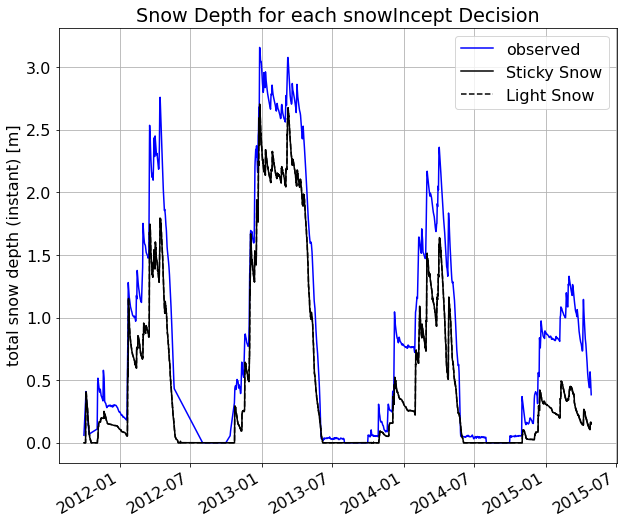

In [17]:
# Plot results
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 16})
plt.plot(s_clm.output['time'],obs_interp/100, label='observed', color='blue')
s_thick_sticky.output['scalarSnowDepth'].plot(label='Sticky Snow', 
                                              color='black', linestyle='-')
s_thick_light.output['scalarSnowDepth'].plot(label='Light Snow', 
                                             color='black', linestyle='--')
plt.title('Snow Depth for each snowIncept Decision')
plt.grid()
plt.xlabel('')
plt.legend()
plt.show()

In [18]:
# Calculate the RMSE of snowIncept simulation and the observed snow depth
rmse_sticky = mean_squared_error(obs_interp/100, s_thick_sticky.output['scalarSnowDepth'], squared=True)
rmse_light = mean_squared_error(obs_interp/100, s_thick_light.output['scalarSnowDepth'], squared=True)

# Determine the best fit snowIncept simulation
rmse_min = np.min([rmse_sticky, rmse_light])

# Print the best fit snowIncept decision
if rmse_min==rmse_sticky:
    print('Best fit = stickySnow')
elif rmse_min==rmse_light:
    print('Best fit = lightSnow')
    
print('RMSE = ',np.round(rmse_min,4),' m')
print('Use this snowIncept decision in the following steps.')

Best fit = stickySnow
RMSE =  0.1788  m
Use this snowIncept decision in the following steps.
